<h1> Libraries </h1>

In [1]:
import os, sys
import numpy as np
import cv2
import scipy
import moviepy.editor as mpe
from moviepy.video.io.bindings import mplfig_to_npimage

from matplotlib import pyplot as plt

%matplotlib inline

np.set_printoptions(precision=4, linewidth=100)

In [2]:
# # Run following code if you occurred error in below cell
# import imageio
# imageio.plugins.ffmpeg.download()

In [3]:
path_003 = "../Handson_BR/dataset/Video_003/Video_003.avi"
path_008 = "./dataset/Video_008/Video_008.avi"
video = mpe.VideoFileClip(path_003)
video.subclip(0,30).ipython_display(width=500)

100%|█████████▉| 210/211 [00:00<00:00, 1094.20it/s]


In [4]:
print("Video duration: {}".format(video.duration))
print("Every frame size is {s[0]} * {s[1]}".format(s=video.size))

Video duration: 113.57
Every frame size is 320 * 240


<h1> Create Matrix </h1>

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [6]:
def create_data_matrix_from_video(clip, fps=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i / float(fps))).astype(int), scale).flatten() 
                      for i in range(fps * int(clip.duration))]).T

In [7]:
# Change resolution of image
scale = 100 # scale to X percent (100 means no scaling). CHANGE THIS FOR BETTER RESOLUTIONoriginal_width = video.size[1]
original_width = video.size[1]
original_height = video.size[0]
dims = (int(original_width * scale / 100), int(original_height * scale / 100))
print("Scale every frame to {d[0]} * {d[1]}".format(d=dims)) # single frame dimensions (height x width)

Scale every frame to 240 * 320


In [8]:
original_width

240

In [9]:
# Take times
fps = 100
M = create_data_matrix_from_video(video, fps, scale)
print(M.shape)

(76800, 11300)


### add testing frame

In [156]:
test_frame = np.vstack([scipy.misc.imresize(rgb2gray(cv2.imread("./dataset/Video_003/private_truth/color/color"+str(i)+".bmp")),scale).flatten() for i in range(1,16)]).T
# test_frame = np.vstack([scipy.misc.imresize(rgb2gray(cv2.imread("./dataset/Video_008/private_truth/color/color"+str(i)+".bmp")),scale).flatten() for i in range(1,55)]).T

In [157]:
# combine test_frame with 
M = np.hstack((M,test_frame))

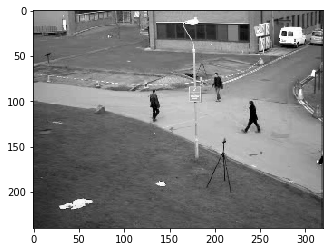

In [10]:
plt.imshow(np.reshape(M[:, 140], dims), cmap='gray')
plt.show()

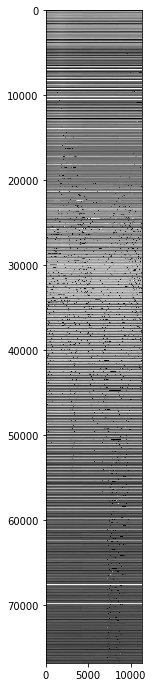

In [11]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')
plt.show()

<h1> Background Removal </h1>

In [12]:
from scipy.sparse.linalg import svds

In [13]:
M = M.astype(float)
U, Sigma, Vt = svds(M, k=2)

In [14]:
U.shape, Sigma.shape, Vt.shape

((76800, 2), (2,), (2, 11300))

In [15]:
low_rank = U @ np.diag(Sigma) @ Vt # low_rank is background

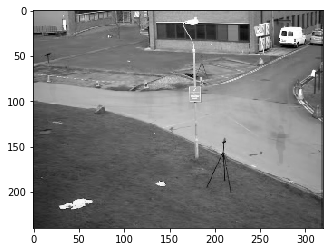

In [16]:
plt.imshow(np.reshape(low_rank[:, 10], dims), cmap='gray')
plt.show()

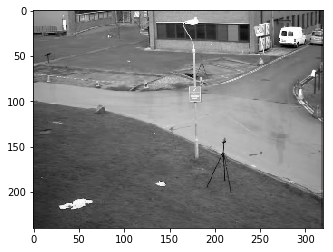

In [17]:
plt.imshow(np.reshape(low_rank[:, -5], dims), cmap='gray')
plt.show()

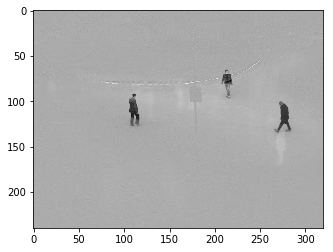

In [18]:
plt.imshow(np.reshape(M[:, 10] - low_rank[:, 10], dims), cmap='gray')
plt.show()

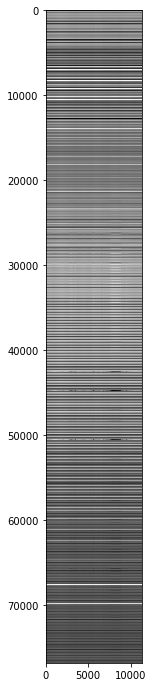

In [19]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')
plt.show()

In [20]:
low_rank.shape

(76800, 11300)

In [21]:
people = M - low_rank

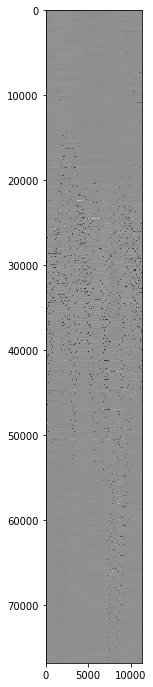

In [22]:
plt.figure(figsize=(12, 12))
plt.imshow(people, cmap='gray');

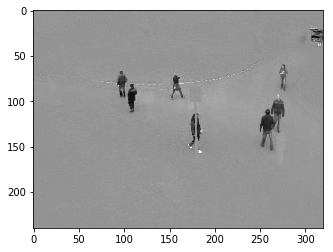

In [23]:
plt.imshow(np.reshape(people[:, -15], dims), cmap='gray');

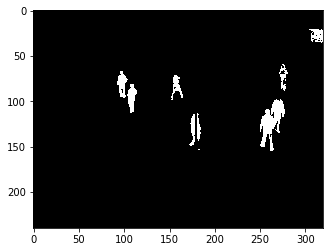

In [24]:
# transform the grayscale image to black and white for validation
(thresh, im_bw) = cv2.threshold(np.reshape(people[:, -15],dims), -35, 255, cv2.THRESH_BINARY_INV)
plt.imshow(im_bw, cmap='gray')

###  Validation

In [49]:
def dice_difference(prediction, groundtruth, k=255):
    dice = np.sum(prediction[groundtruth==k])*2.0 / (np.sum(prediction) + np.sum(groundtruth))
    return dice

In [80]:
predict_frame = []
for i in range(-54,0):
    _, im_bw = cv2.threshold(np.reshape(people[:, i],dims), -30, 255, cv2.THRESH_BINARY_INV)
    predict_frame.append(im_bw)
predict_frame = np.array(predict_frame)
valid_frame = np.array([scipy.misc.imresize(
    cv2.imread("./dataset/Video_008/private_truth/"+str(i)+".bmp")[:,:,0],scale) 
                        for i in range(1,55)])

In [81]:
len(predict_frame)

54

In [82]:
average_dice_difference = np.mean([dice_difference(predict_frame[p], valid_frame[p]) for p in range(54)])
average_dice_difference

0.345564531816609

<h1> Make Video </h1>

In [25]:
people_frames = people.reshape(dims + (-1,))
people_frames.shape

(240, 320, 11300)

In [27]:
M_frames = M.reshape(dims + (-1,))
print(M_frames.shape)

(240, 320, 11300)


In [32]:
combine_frames = np.vstack((M_frames,people_frames))
combine_frames.shape

(480, 320, 11300)

[MoviePy] >>>> Building video ./people_100.mp4
[MoviePy] Writing video ./people_100.mp4



 37%|███▋      | 407/1101 [00:21<00:44, 15.60it/s]


 74%|███████▍  | 815/1101 [00:42<00:13, 21.01it/s]


100%|█████████▉| 1100/1101 [00:57<00:00, 18.24it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./people_100.mp4 



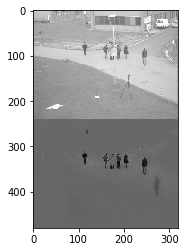

In [33]:
# this takes a while
fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.imshow(combine_frames[..., int(t*fps)], cmap="gray")
    return mplfig_to_npimage(fig)

animation = mpe.VideoClip(make_frame, duration=int((video.duration-1)*0.1))
animation.write_videofile('./people_%s.mp4'%str(scale), fps=fps)

In [85]:
video = mpe.VideoFileClip("./car_%s.mp4"%str(scale))
video.ipython_display(width=500)

100%|█████████▉| 700/701 [00:00<00:00, 997.87it/s]


### Reference
- https://zulko.github.io/moviepy/getting_started/working_with_matplotlib.html

# Improvement using Robust PCA

In [86]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca

In [87]:
TOL=1e-9
MAX_ITERS=3

def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

def _svd(M, rank): 
    return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

def norm_op(M): 
    return _svd(M, 1)[1][0]

def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

In [160]:
L, S, examples =  pcp(M, maxiter=5, k=10)

rank sv: 1
error:  0.14899843308965677
rank sv: 567
error:  0.060704076312973934
rank sv: 68
error:  0.00905531332616602
rank sv: 634
error:  0.000696447020661089
rank sv: 1200
error:  1.613812737176745e-05


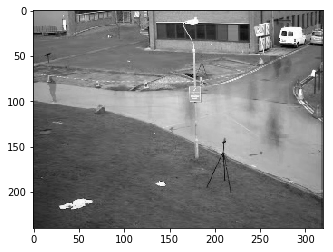

In [161]:
plt.imshow(L[:,-15].reshape(dims), cmap="gray")
plt.show()

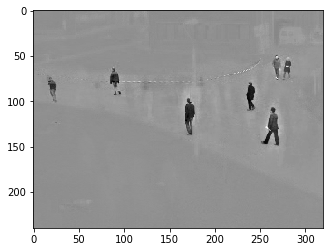

In [162]:
plt.imshow(S[:,-15].reshape(dims), cmap="gray")
plt.show()

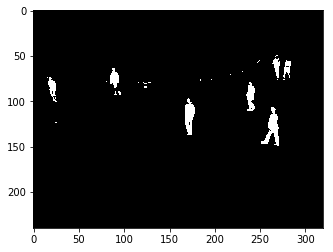

In [192]:
# transform the grayscale image to black and white for validation
(thresh, im_bw) = cv2.threshold(np.reshape(S[:, -15],dims), -20, 255, cv2.THRESH_BINARY_INV)
plt.imshow(im_bw, cmap='gray')

In [190]:
predict_frame = []
for i in range(-15,0):
    _, im_bw = cv2.threshold(np.reshape(S[:, i],dims), -20, 255, cv2.THRESH_BINARY_INV)
    predict_frame.append(im_bw)
predict_frame = np.array(predict_frame)
valid_frame = np.array([scipy.misc.imresize(
    cv2.imread("./dataset/Video_003/private_truth/"+str(i)+".bmp")[:,:,0],scale) 
                        for i in range(1,16)])

In [191]:
average_dice_difference = np.mean([dice_difference(predict_frame[p], valid_frame[p]) for p in range(15)])
average_dice_difference

0.8654584814340489

(240, 320, 7954)
[MoviePy] >>>> Building video ./car_robustPCA_100.mp4
[MoviePy] Writing video ./car_robustPCA_100.mp4


100%|█████████▉| 700/701 [00:34<00:00, 20.42it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./car_robustPCA_100.mp4 



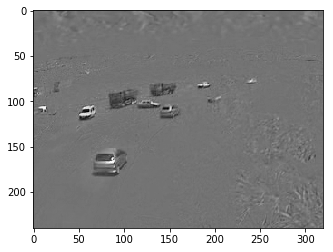

In [145]:
# make video
S_frames = S.reshape(dims + (-1,))
print(S_frames.shape)
# this takes a while
fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.imshow(S_frames[..., int(t*fps)], cmap="gray")
    return mplfig_to_npimage(fig)

animation = mpe.VideoClip(make_frame, duration=int((video.duration-1)*0.1))
animation.write_videofile('./car_robustPCA_%s.mp4'%str(scale), fps=fps)

In [146]:
video = mpe.VideoFileClip("./car_robustPCA_%s.mp4"%str(scale))
video.ipython_display(width=500)

100%|█████████▉| 700/701 [00:00<00:00, 1134.10it/s]
